# Markov chain Monte Carlo
Now that we are able to create a guess of the parameters for the Gaussian, we can use MCMC to improve our intial guess and give us a better result.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.table import Table
import emcee
#%matplotlib inline
%config InlineBackend.figure_format='retina'

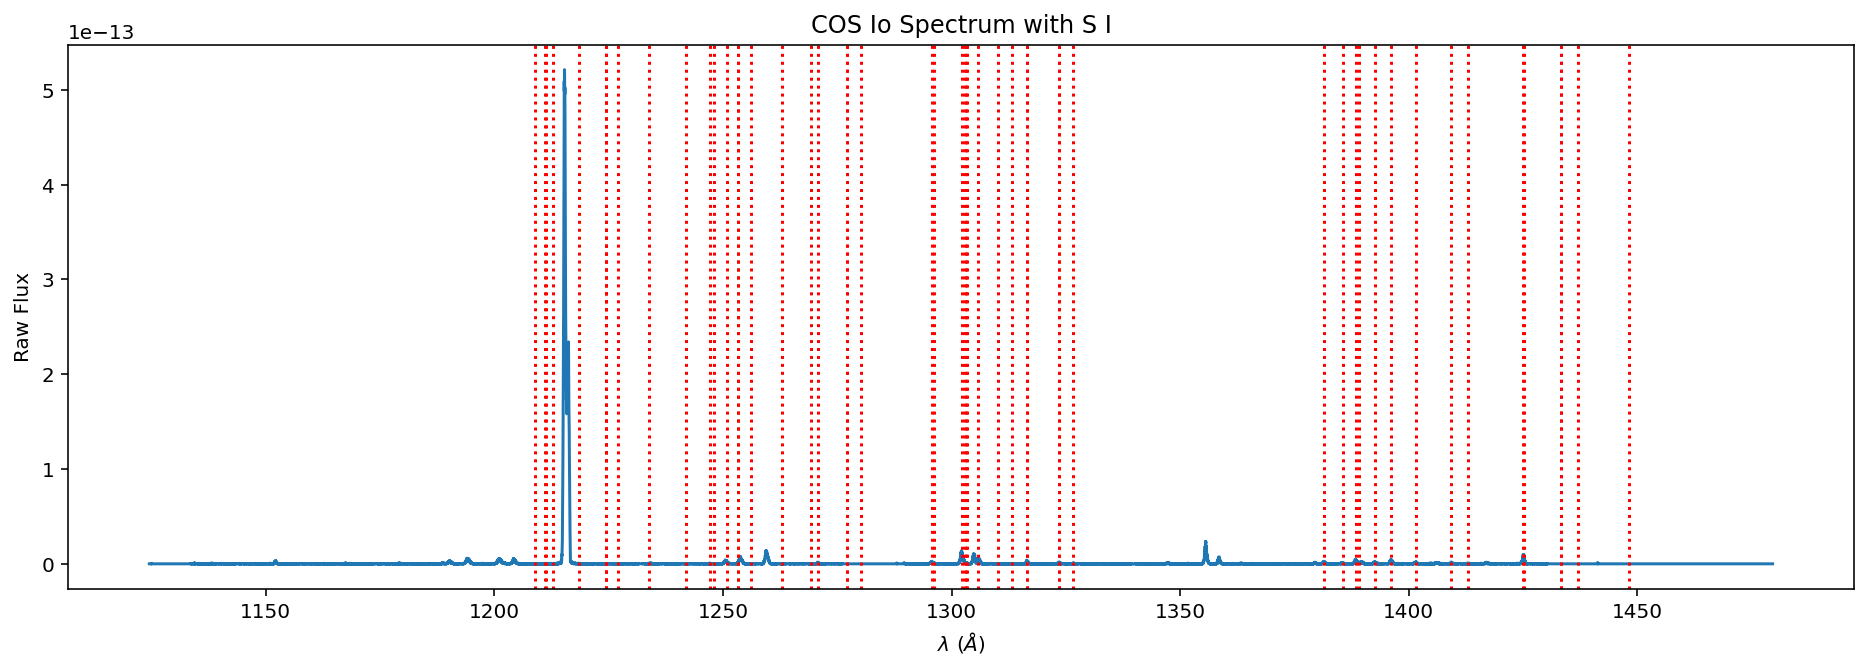

In [2]:
hdulist = fits.open('../data/composite_Io_eclipsed.fits')
evt_data = Table(hdulist[1].data)
image_data = hdulist[1].data
df = pd.read_csv('../data/Io_Master_Line_List (1).csv') #spaces in csv file will make df object type and not float64
line = "S I"
target_mask = df.Species.str.endswith(line) #probably a better function but idk it right now
df = df[target_mask]
df_wavelength = df['Wavelength']
df_species = df['Species']
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum with S I")
for xc in df_wavelength:
    plt.axvline(x=xc, color = 'red', linestyle = 'dotted')

(-0.005, 0.15)

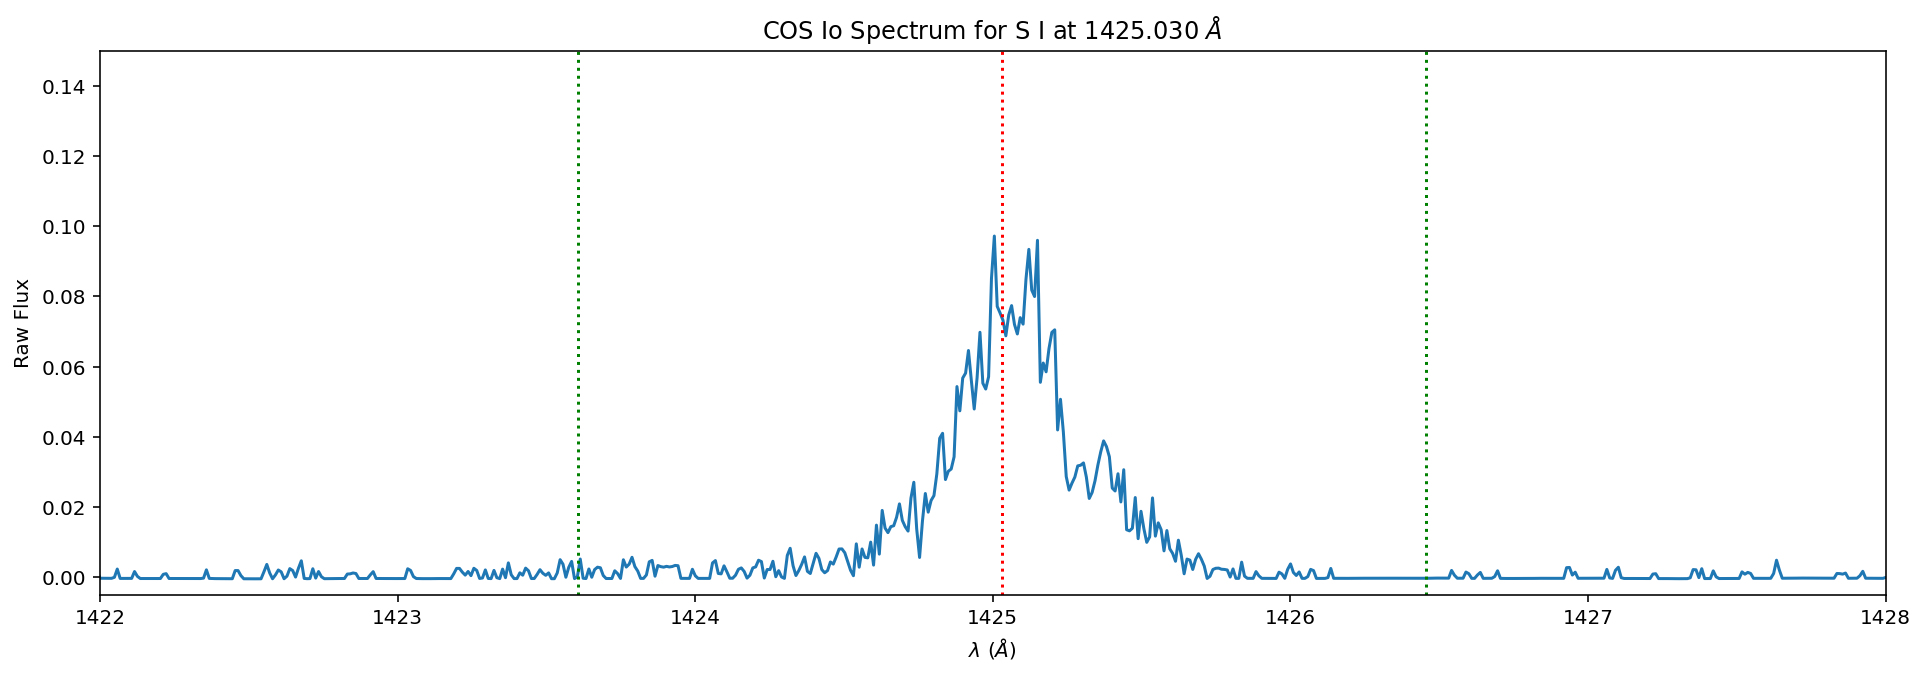

In [5]:
line = 1425.030
left_bound = 0.999*line
right_bound = 1.001*line
plt.figure(figsize=(16, 5))
plt.plot(evt_data['WAVELENGTH'].T, evt_data['FLUX'].T/10**-13) #make it columns instead of rows bc otherwise will be a blank plot
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.title("COS Io Spectrum for S I at 1425.030 $\AA$")
plt.axvline(line, color = 'red', linestyle = 'dotted')
plt.axvline(left_bound, color = 'green', linestyle = 'dotted')
plt.axvline(right_bound, color = 'green', linestyle = 'dotted')
plt.xlim(1422,1428)
plt.ylim(-0.005,0.15)

In [6]:
sub_region = (evt_data['WAVELENGTH'] > left_bound) & (evt_data['WAVELENGTH'] < right_bound) #only take values within this area
wl = evt_data['WAVELENGTH'][sub_region]
flux = evt_data['FLUX'][sub_region]

In [7]:
def generative_model(m, b, A, mu, logw, int_wl = line):
    """Generate the model given parameters"""
    continuum = m * (wl - int_wl) + b
    w = np.exp(logw)
    gaussian = A * np.exp(-0.5*(wl-mu)**2/w**2)
    return continuum + gaussian

In [8]:
m_guess, b_guess, A_guess, mu_guess, logw_guess = 0, 0, 0.09, line+.01, np.log(0.2)
flux_guess = generative_model(m_guess, b_guess, A_guess, mu_guess, logw_guess)

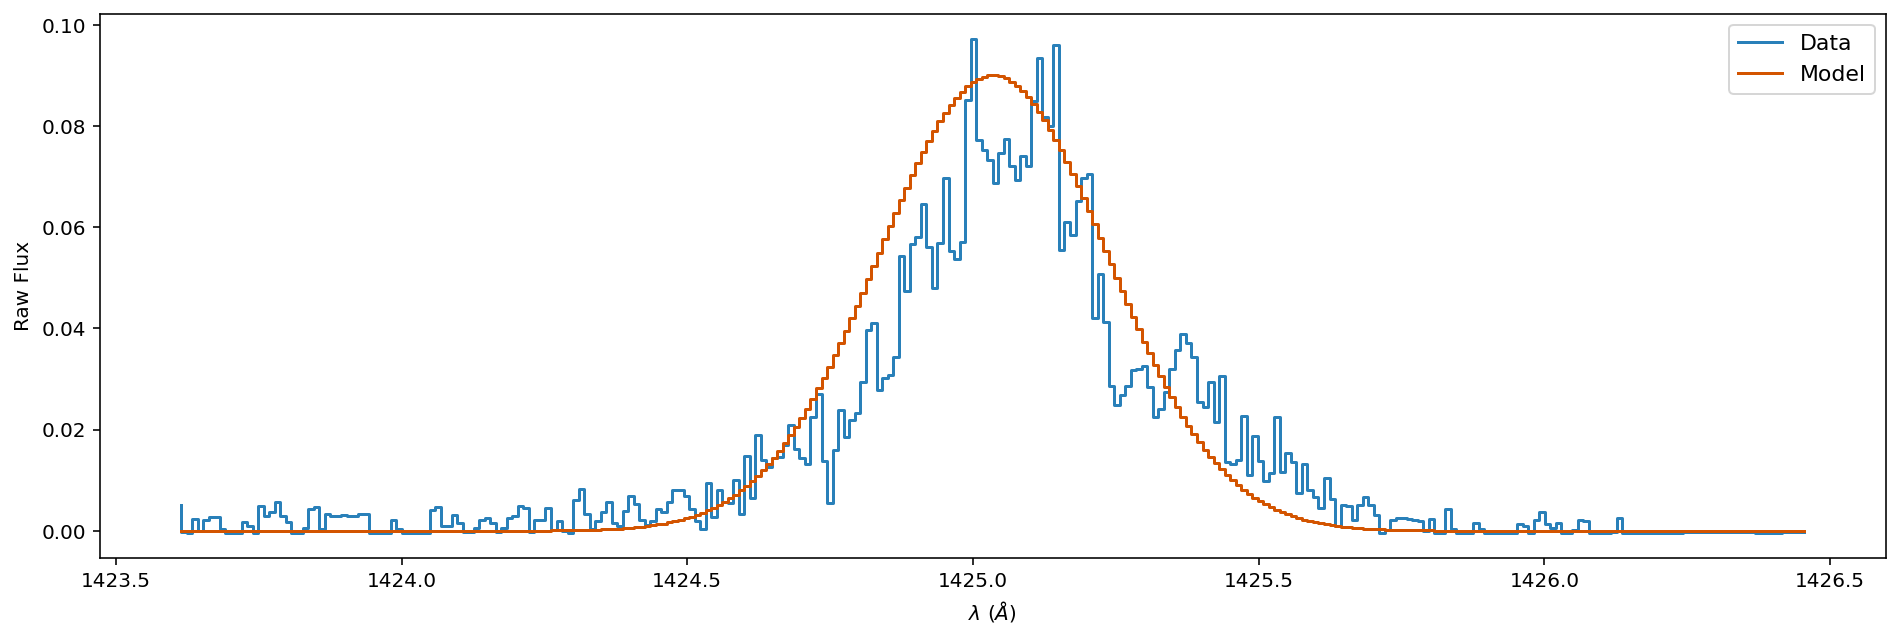

In [9]:
plt.figure(figsize=(16, 5))
plt.step(wl, flux/10**-13, label='Data', color='#2980b9');
plt.step(wl, flux_guess, label='Model', color='#d35400');
plt.xlabel('$\lambda$ ($\AA$)');
plt.ylabel('Raw Flux')
plt.legend(fontsize=11);

In [12]:
def log_likelihood(theta):
    m, b, A, mu, logw = theta
    model = generative_model(m, b, A, mu, logw, int_wl = line)
    residual = flux - model
    chi_squared = np.sum(residual** 2 / unc**2)
    return -0.5 * chi_squared

In [14]:
theta_guess = np.array([m_guess, b_guess, A_guess, mu_guess, logw_guess])
#log_likelihood(theta_guess)

In [15]:
n_walkers = 32
n_params = 5
pos = theta_guess + 1e-4 * np.random.randn(n_walkers, n_params) #intial guess position

In [16]:
n_steps = 5000

In [17]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, log_likelihood)
sampler.run_mcmc(pos, n_steps, progress=True);

emcee: Exception while calling your likelihood function:
  params: [-6.02114388e-05 -4.50275126e-05  8.99345290e-02  1.42504004e+03
 -1.60947157e+00]
  args: []
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "C:\Users\jojoa\.conda\envs\io_env\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-12-b0b561979620>", line 5, in log_likelihood
    chi_squared = np.sum(residual** 2 / unc**2)
NameError: name 'unc' is not defined


NameError: name 'unc' is not defined